In [1]:
!. /vol/cuda/11.4.120-cudnn8.2.4/setup.sh
!nvcc --version

/bin/bash: nvcc: command not found


In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax.config import config

from inducing_points import random_select, greedy_variance
import logger as logging
logger = logging.init_logger(log_level=logging.DEBUG)

config.update("jax_enable_x64", True)
%matplotlib inline

In [3]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP, init_kernel_fn
import jax.numpy as jnp

model = FCN
model_params = dict(
            kernel_batch_size=0, 
            device_count=-1, 
            num_layers=2,
            nonlinearity=stax.Relu
            )

2022-07-18 22:18:25.980230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vol/lab/mac/cadence/smv/lib


In [4]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)
# X_m = jnp.linspace(-1., 1., m).reshape(-1, 1)
# X_m = random_select(X, 30)
init_stds = jnp.array([1., 1.], dtype=jnp.float64)
# X_m = greedy_variance(X, 30, init_kernel_fn(model, init_stds, model_params))

X.shape, y.shape, X_m.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (30, 1), (1000, 1), (1000, 1))

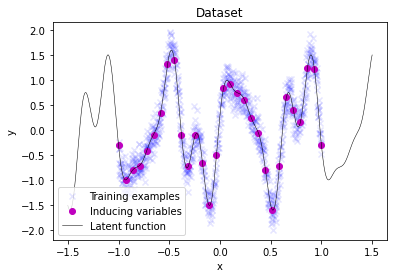

In [5]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [6]:
snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1, noise_variance=sigma_y**2, init_stds=init_stds, batch_size=3)

# ll = snngp.log_likelihood()
lb = snngp.lower_bound()
ub = snngp.upper_bound()
lb, ub, ub-lb

[2022-07-18 22:18:37,065 DEBUG] (snngp:91) stds: [ 5. 20.]
[2022-07-18 22:18:38,477 DEBUG] (snngp:99) kuu: (30, 30)
[2022-07-18 22:18:48,247 DEBUG] (snngp:104) kuf: (30, 1000)


(DeviceArray(45.85056226, dtype=float64),
 DeviceArray(579.65009591, dtype=float64),
 DeviceArray(533.79953365, dtype=float64))

6.204652766638681


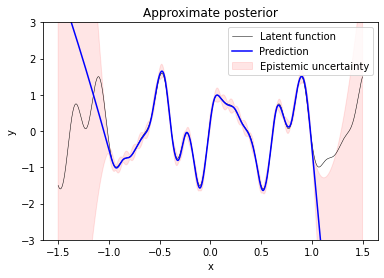

In [7]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
f_test_std = np.sqrt(f_test_cov)
print(jnp.var(f_test_std))

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.legend()

In [12]:
opt_params = snngp.optimize()
print(opt_params)
ll = snngp.log_likelihood()
lb = snngp.lower_bound()
ub = snngp.upper_bound()
lb, ll-lb, ub-lb

[2022-07-15 15:39:51,678 INFO] (snngp:254) Optimizing...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83535D+03    |proj g|=  5.18830D+03


 This problem is unconstrained.



At iterate    1    f=  1.53549D+03    |proj g|=  1.75202D+03

At iterate    2    f=  8.24986D+02    |proj g|=  9.86507D+02

At iterate    3    f=  2.59988D+02    |proj g|=  3.72606D+02

At iterate    4    f=  4.85541D+01    |proj g|=  1.34913D+02

At iterate    5    f= -6.10629D+00    |proj g|=  4.84075D+01

At iterate    6    f= -2.05821D+01    |proj g|=  2.74101D+01

At iterate    7    f= -2.52815D+01    |proj g|=  1.80620D+01

At iterate    8    f= -3.03843D+01    |proj g|=  2.02069D+01

At iterate    9    f= -3.71136D+01    |proj g|=  5.90970D+00

At iterate   10    f= -3.82882D+01    |proj g|=  9.76205D+00

At iterate   11    f= -3.95813D+01    |proj g|=  3.40532D+00

At iterate   12    f= -4.00307D+01    |proj g|=  7.36959D-01

At iterate   13    f= -4.01990D+01    |proj g|=  5.70189D-01

At iterate   14    f= -4.02333D+01    |proj g|=  1.59336D+00

At iterate   15    f= -4.02442D+01    |proj g|=  9.15254D-02

At iterate   16    f= -4.02445D+01    |proj g|=  2.36486D-02

At iter

[2022-07-15 15:41:10,820 INFO] (snngp:258) Optimized for 18 iters; Success: True; Result: [3.87022147 5.18501709]



At iterate   18    f= -4.02445D+01    |proj g|=  1.13306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     19      1     0     0   1.133D-04  -4.024D+01
  F =  -40.244471404814703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
[3.89086076 5.19060131]


[2022-07-15 15:41:11,600 DEBUG] (snngp:186) (1000, 1000), (1000, 1)
[2022-07-15 15:41:11,606 DEBUG] (snngp:188) (1000, 1)
[2022-07-15 15:41:11,607 DEBUG] (snngp:192) -319.2604923268116
[2022-07-15 15:41:11,612 DEBUG] (snngp:69) stds: [3.89086076 5.19060131]


(DeviceArray(40.24447141, dtype=float64),
 DeviceArray(-359.50496374, dtype=float64),
 DeviceArray(542.47072135, dtype=float64))

1.7400660425398178


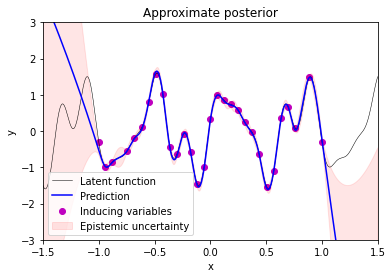

In [13]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
f_test_std = np.sqrt(f_test_cov)
print(jnp.var(f_test_std))

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.scatter(snngp.inducing_points, func(snngp.inducing_points), label='Inducing variables', c='m')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.xlim(-1.5, 1.5)
plt.legend()

# Study the characteristics of hyper-params

In [14]:
for i in [2, 5, 10 ,20]:
    stds = jnp.array([5., 5.], dtype=jnp.float64)
    model = FCN
    layer_num = i
    model_params = dict(
                kernel_batch_size=0, 
                device_count=-1, 
                num_layers=layer_num,
                nonlinearity=stax.Relu
                )
    
    snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1, noise_variance=sigma_y**2, init_stds=stds)

    lb = snngp.lower_bound()
    ub = snngp.upper_bound()
    f_test, f_test_cov = snngp.predict(X_test, diag=True)
    f_test_std = np.sqrt(f_test_cov)

    plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
    plt.plot(X_test, f_test, label='Prediction', c='b')
    plt.fill_between(X_test.ravel(), 
                    f_test.ravel() + 2 * f_test_std.ravel(), 
                    f_test.ravel() - 2 * f_test_std.ravel(),
                    label='Epistemic uncertainty',
                    color='r', alpha=0.1)
    plt.title('Approximate posterior')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-3.0, 3.0)
    plt.legend()
    plt.savefig(f"figures/hyperparams/{stds.tolist()}_{layer_num}_{ub:.4f}_{lb:.4f}.pdf")
    plt.close()
    
    

[2022-07-18 18:46:45,499 DEBUG] (snngp:84) stds: [5. 5.]
[2022-07-18 18:46:45,499 DEBUG] (snngp:84) stds: [5. 5.]
[2022-07-18 18:46:46,197 DEBUG] (snngp:88) kuu: (30, 30)
[2022-07-18 18:46:46,197 DEBUG] (snngp:88) kuu: (30, 30)
[2022-07-18 18:46:46,904 DEBUG] (snngp:93) kuf: (30, 1000)
[2022-07-18 18:46:46,904 DEBUG] (snngp:93) kuf: (30, 1000)
[2022-07-18 18:46:47,808 DEBUG] (snngp:84) stds: [5. 5.]
[2022-07-18 18:46:47,808 DEBUG] (snngp:84) stds: [5. 5.]
[2022-07-18 18:46:49,194 DEBUG] (snngp:88) kuu: (30, 30)
[2022-07-18 18:46:49,194 DEBUG] (snngp:88) kuu: (30, 30)
[2022-07-18 18:46:50,852 DEBUG] (snngp:93) kuf: (30, 1000)
[2022-07-18 18:46:50,852 DEBUG] (snngp:93) kuf: (30, 1000)
[2022-07-18 18:46:52,417 DEBUG] (snngp:84) stds: [5. 5.]
[2022-07-18 18:46:52,417 DEBUG] (snngp:84) stds: [5. 5.]
[2022-07-18 18:46:55,072 DEBUG] (snngp:88) kuu: (30, 30)
[2022-07-18 18:46:55,072 DEBUG] (snngp:88) kuu: (30, 30)
[2022-07-18 18:46:58,197 DEBUG] (snngp:93) kuf: (30, 1000)
[2022-07-18 18:46:58,